# Regional SE Aus domain forced by GLORYS and ERA5 reanalysis datasets
Modified (very) slightly from regional MOM6 demo here https://regional-mom6.readthedocs.io/en/latest/demo_notebooks/reanalysis-forced.html

This code uses `regional-mom6` package to set up a regional ocean configuration with MOM6. The recipe uses input from: 

Input Type | Source | Subsets required
---|---|---
Surface | [ERA5 surface forcing](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5) | Data from 2003; whole globe or subset around our domain
Ocean | [GLORYS reanalysis product](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/description) | Boundary segments & initial condition; see section 2 for details.   
Bathymetry | [GEBCO](https://www.gebco.net/data_and_products/gridded_bathymetry_data/) | whole globe or subset around domain

On gadi, ERA5 data lives at `/g/data/rt52/era5/single-levels/reanalysis`

In [3]:
import matplotlib.pyplot as plt
import xarray as xr
import os
from pathlib import Path
import subprocess
from dask.distributed import Client

import regional_mom6 as rmom6
print("using regional-mom6 version " + rmom6.__version__)

using regional-mom6 version 0.6.1


Start a dask client.

In [3]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41719,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:32815,Total threads: 1
Dashboard: /proxy/37113/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:43463,


## Step 0: Your personal environment variables

Some user-custom directories are automatically sourced from the user's environment variables below.

In [4]:
scratch = subprocess.run("echo /scratch/$PROJECT/$USER", shell=True, capture_output=True, text=True).stdout.strip()
gdata = subprocess.run("echo /g/data/$PROJECT/$USER", shell=True, capture_output=True, text=True).stdout.strip()
home = subprocess.run("echo ~", shell=True, capture_output=True, text=True).stdout.strip()

for (dir_name, dir) in zip(("scratch", "gdata", "home"), (scratch, gdata, home)):
    print(dir_name, "directory:", dir)

scratch directory: /scratch/jk72/mxr581
gdata directory: /g/data/jk72/mxr581
home directory: /home/581/mxr581


Users can override the paths that were sourced above from their enviroment variables by redefining a directory as a string. For example:

```python
scratch = "/scratch/ab12/xz1234/my_custom_directory_for_this_experiment"
```

## Step 1: Choose our domain, define workspace paths

To make sure that things are working I'd recommend starting with the default example defined below. If this runs ok, then change to a domain of your choice and hopefully it runs ok too! If not, check the [README](https://github.com/COSIMA/regional-mom6/blob/main/README.md) and [documentation](https://regional-mom6.readthedocs.io/) for troubleshooting tips.

You can log in and use [Copernicus GUI](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/download) to find the latitude-longitude ranges of the domain of choice and then paste below.

In [5]:
expt_name = "SEAu_1km"

latitude_extent = [-55, -30]
longitude_extent = [131, 156]

date_range = ["2020-01-01 00:00:00", "2020-02-01 00:00:00"]

## Place where all the input files go
input_dir = f"{scratch}/regional_mom6_configs/{expt_name}/"

## Directory where we'll be running the experiment from
run_dir = f"{home}/mom6_rundirs/{expt_name}/"

## Directory where the compiled FRE tools are located (needed to construct mask tables)
toolpath_dir = "/g/data/ik11/mom6_tools/tools"

## Directory where ocean model cut-outs go before processing
tmp_dir = f"{gdata}/{expt_name}"

## Path to where your raw ocean forcing files are stored
glorys_path = f"{gdata}/glorys/{expt_name}"

## if directories don't exist, create them
for path in (run_dir, tmp_dir, input_dir):
    os.makedirs(str(path), exist_ok=True)

## Step 2: Make experiment object
The `regional_mom6.experiment` contains the regional domain basics, and also generates the horizontal and vertical grids, `hgrid` and `vgrid` respectively, and sets up the directory structures. 

In [6]:
expt = rmom6.experiment(
    longitude_extent = longitude_extent,
    latitude_extent = latitude_extent,
    date_range = date_range,
    resolution = 0.027,
    number_vertical_layers = 100,
    layer_thickness_ratio = 15,
    depth = 5500,
    mom_run_dir = run_dir,
    mom_input_dir = input_dir,
    toolpath_dir = toolpath_dir,
    read_existing_grids = True
)

## Step 3: Prepare ocean forcing data

We need to cut out our ocean forcing. The package expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is `"east_unprocessed"` for segments and `"ic_unprocessed"` for the initial condition.

In this notebook, we are forcing with the Copernicus Marine "Glorys" reanalysis dataset. There's a function in the `mom6-regional` package that generates a bash script to download the correct boundary forcing files for your experiment. First, you will need to create an account with Copernicus, and you'll be prompted for your username and password when you try to run the bash script.

The function is called `get_glorys_rectangular` because the fully automated setup is only supported for domains with boundaries parallel to lines of longitude and latitude. To download more complex domain shapes you can call `rmom6.get_glorys_data` directly.

In [7]:
expt.get_glorys_rectangular(
    raw_boundaries_path=glorys_path,
    boundaries=["north", "south", "east", "west"],
)

script `get_glorys_data.sh` has been greated at /g/data/jk72/mxr581/glorys/SEAu_1km.
 Run this script via bash to download the data from a terminal with internet access. 
You will need to enter your Copernicus Marine username and password.
If you don't have an account, make one here:
https://data.marine.copernicus.eu/register


## Step 4: Set up bathymetry

Similarly to ocean forcing, we point the experiment's `setup_bathymetry` method at the location of the file of choice and also provide the variable names. We don't need to preprocess the bathymetry since it is simply a two-dimensional field and is easier to deal with. Afterwards you can inspect `expt.bathymetry` to have a look at the regional domain.

After running this cell, your input directory will contain other bathymetry-related things like the ocean mosaic and mask table too. The mask table defaults to a 10x10 layout and can be modified later.

In [7]:
expt.setup_bathymetry(
    bathymetry_path='/g/data/ik11/inputs/GEBCO_2022/GEBCO_2022.nc',
    longitude_coordinate_name='lon',
    latitude_coordinate_name='lat',
    vertical_coordinate_name='elevation',
    minimum_layers=1
    )

Begin regridding bathymetry...

If this process hangs it means that the chosen domain might be too big to handle this way. After ensuring access to appropriate computational resources, try calling ESMF directly from a terminal in the input directory via

mpirun ESMF_Regrid -s bathymetry_original.nc -d bathymetry_unfinished.nc -m bilinear --src_var elevation --dst_var elevation --netcdf4 --src_regional --dst_regional

For details see https://xesmf.readthedocs.io/en/latest/large_problems_on_HPC.html

Afterwards, we run 'tidy_bathymetry' method to skip the expensive interpolation step, and finishing metadata, encoding and cleanup.
Regridding in parallel: True
Regridding finished. Now calling `tidy_bathymetry` method for some finishing touches...
done.ng in regridded bathymetry to fix up metadata...


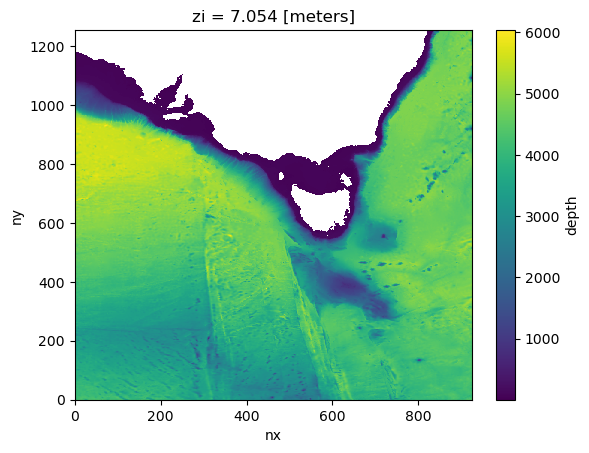

In [8]:
expt.bathymetry.depth.plot()

In [9]:
#expt.vgrid.zl.plot(marker = '.', y='zl', yincrease=False, figsize=(4, 8))

##  Step 5: Handle the ocean forcing - where the magic happens

This cuts out and interpolates the initial condition as well as all boundaries (unless you don't pass it boundaries).

The dictionary maps the MOM6 variable names to what they're called in your ocean input file. Notice how for GLORYS, the horizontal dimensions are `latitude` and `longitude`, vs `xh`, `yh`, `xq`, `yq` for MOM6. This is because for an 'A' grid type tracers share the grid with velocities so there's no difference.

If one of your segments is land, you can delete its string from the 'boundaries' list. You'll need to update MOM_input to reflect this though so it knows how many segments to look for, and their orientations.

In [10]:
# Define a mapping from the GLORYS variables and dimensions to the MOM6 ones
ocean_varnames = {"time": "time",
                  "yh": "latitude",
                  "xh": "longitude",
                  "zl": "depth",
                  "eta": "zos",
                  "u": "uo",
                  "v": "vo",
                  "tracers": {"salt": "so", "temp": "thetao"}
                  }

# Set up the initial condition
expt.initial_condition(
    glorys_path + "/ic_unprocessed.nc", # directory where the unprocessed initial condition is stored, as defined earlier
    ocean_varnames,
    arakawa_grid="A"
    )    

# Set up the four boundary conditions. Remember that in the glorys_path, we have four boundary files names north_unprocessed.nc etc. 
expt.rectangular_boundaries(
        glorys_path,
        ocean_varnames,
        boundaries = ["south", "north", "west", "east"],
        arakawa_grid = "A"
        )


INITIAL CONDITIONS
Done.dding Velocities... 
Done.dding Tracers... 
Done.dding Free surface... 
Saving outputs... done setting up initial condition.
[########################################] | 100% Completed | 105.42 ms
Done.
[########################################] | 100% Completed | 105.41 ms
Done.
[########################################] | 100% Completed | 105.45 ms
Done.
[########################################] | 100% Completed | 105.96 ms
Done.


We can inspect all variable in the experiment by calling

In [17]:
#vars(expt)

We can plot our the interpolated initial condition. It's a good idea to check and ensure things look reasonble, especially near the region's boundaries.

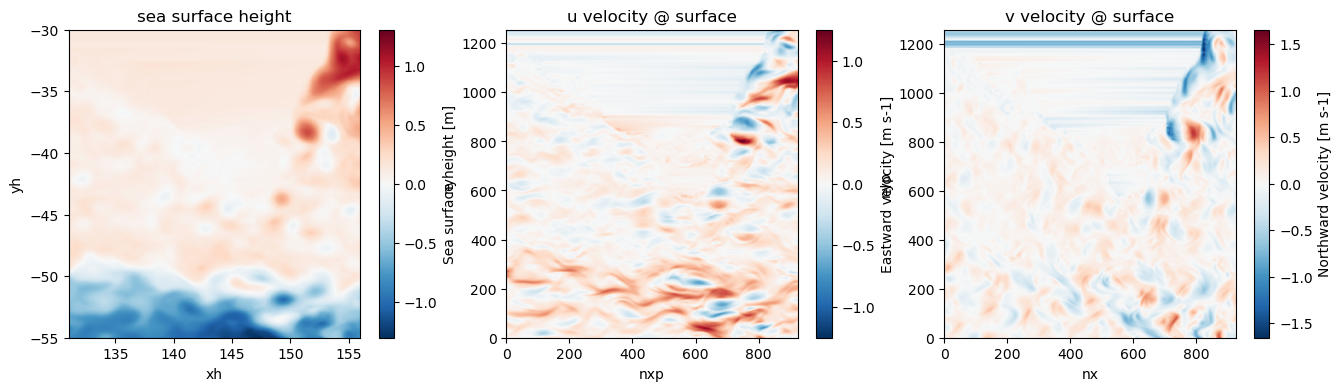

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))

expt.ic_eta.plot(ax=axes[0])
expt.ic_vels.u.sel(zl=0, method='nearest').plot(ax=axes[1])
expt.ic_vels.v.sel(zl=0, method='nearest').plot(ax=axes[2])

axes[0].set_title("sea surface height")
axes[1].set_title("u velocity @ surface")
axes[2].set_title("v velocity @ surface");

To ensure that no spurious gradients have emerged at the boundaries (e.g., during the interpolation) we plot a few slices, e.g.,

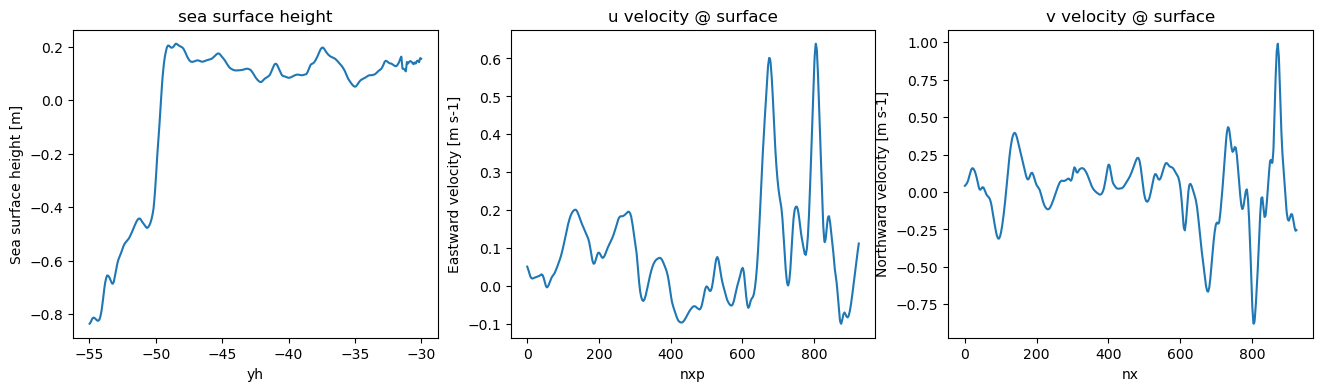

In [19]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))

expt.ic_eta.isel(xh=0).plot(ax=axes[0])
expt.ic_vels.u.isel(ny=0, zl=0).plot(ax=axes[1])
expt.ic_vels.v.isel(nyp=0, zl=0).plot(ax=axes[2])

axes[0].set_title("sea surface height")
axes[1].set_title("u velocity @ surface")
axes[2].set_title("v velocity @ surface");

## Step 6: Run the FRE tools

This is just a wrapper for the FRE tools needed to make the mosaics and masks for the experiment. The only thing you need to tell it is the processor layout. In this case we're asking for a 10 by 10 grid of 100 processors.

In [20]:
expt.FRE_tools(layout = (12, 12)) ## Here the tuple defines the processor layout

Running GFDL's FRE Tools. The following information is all printed by the FRE tools themselves
NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
OUTPUT FROM MAKE SOLO MOSAIC:

CompletedProcess(args='/g/data/ik11/mom6_tools/tools/make_solo_mosaic/make_solo_mosaic --num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc', returncode=0)


cp: './ocean_mosaic.nc' and 'ocean_mosaic.nc' are the same file
cp: './hgrid.nc' and 'hgrid.nc' are the same file


cp ./hgrid.nc hgrid.nc 

NOTE from make_coupler_mosaic: the ocean land/sea mask will be determined by field depth from file bathymetry.nc
mosaic_file is grid_spec.nc

***** Congratulation! You have successfully run make_quick_mosaic
OUTPUT FROM QUICK MOSAIC:

CompletedProcess(args='/g/data/ik11/mom6_tools/tools/make_quick_mosaic/make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog bathymetry.nc', returncode=0)

 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=144

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
topog_file = bathymetry.nc
min_pe = 144
max_pe = 144
layout = 12, 12
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (mosaic grid) grid which contains field gridfiles

==>NOTE from get_boundary_type: x_boundary_type is 

## Step 7: Set up ERA5 forcing:

Here we assume the ERA5 dataset is stored somewhere on the system we are working on. 

Below is a table showing ERA5 characteristics and what needs to be done to sort it out.

**Required ERA5 data**:

Name | ERA5 filename | ERA5 variable name | Units
---|---|---|---
Surface Pressure | sp | sp | Pa 
Surface Temperature | 2t | t2m | K 
Meridional Wind | 10v | v10 | m/s 
Zonal Wind | 10u | u10 | m/s 
Specific Humidity | - | - | kg/kg, calculated from dewpoint temperature
Dewpoint Temperature | 2d | d2m | K


We calculate specific humidity $q$ from dewpoint temperature $T_d$ and surface pressure $P$ via saturation vapour pressure $P_v$.

$$P_v = 10^{8.07131 - \frac{1730.63}{233.426 + T}} \frac{101325}{760} \; \textrm{[Pascal]} $$

$$q = 0.001 \times 0.622  \frac{P_v}{P}$$

In [11]:
expt.setup_era5("/g/data/rt52/era5/single-levels/reanalysis")

## Step 8: Modify the default input directory to make a (hopefully) runnable configuration out of the box

This step copies the default directory and modifies the `MOM_layout` files to match your experiment by inserting the right number of x, y points and CPU layout.

To run MOM6 using the [payu infrastructure](https://github.com/payu-org/payu), provide the keyword argument `using_payu = True` to the `setup_run_directory` method and an example `config.yaml` file will be appear in the run directory. The `config.yaml` file needs to be modified manually to add the locations of executables, etc.

In [12]:
expt.setup_run_directory(surface_forcing = "era5")

Mask table mask_table.17.12x12 read. Using this to infer the cpu layout (12, 12), total masked out cells 17, and total number of CPUs 127.
Number of CPUs required:  127


## Step 9: Run and Troubleshoot!

To do this, navigate to your run directory in terminal. If you're working on NCI, you can run your model via:

```
module load conda/analysis3
payu setup -f
payu run -f
```

By default `input.nml` is set to only run for 5 days as a test. If this is successful, you can modify this file to then run for longer.

Ideally, MOM6 runs. If not, the first thing you should try is reducing the timestep. You can do this by adding `#override DT=XXXX` to your `MOM_override` file. 

If there's strange behaviour on your boundaries, you could play around with the `nudging timescale` (an example is already included in the `MOM_override` file). Sometimes, if your boundary has a lot going on (like all of the eddies spinning off the western boundary currents or off the Antarctic Circumpolar current), it can be hard to avoid these edge effects. This is because the chaotic, submesoscale structures developed within the regional domain won't match the flow at the boundary. 

Another thing that can go wrong is little bays that create non-advective cells at your boundaries. Keep an eye out for tiny bays where one side is taken up by a boundary segment. You can either fill them in manually, or move your boundary slightly to avoid them
